In [43]:
import matplotlib.pyplot as plt
import numpy as np
import sys
import healpy as hp
from tqdm import tqdm
import pickle as pl
import emcee
sys.path.append('../')
import os
%matplotlib inline

In [58]:
%load_ext autoreload
%autoreload 2
from dance.qe import Reconstruct
from dance.delens import Delens
from dance.utils import bin_power_spectrum,plot_posterior

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
basedir = '/mnt/sdceph/users/alonappan/DANCE_debug'
datadir = '/mnt/home/alonappan/workspace/dance/data'

In [5]:
fname = os.path.join(datadir,'a_p_gauss.pkl')
if os.path.isfile(fname):
    data = pl.load(open(fname,'rb'))
    cl_aa = data['cl_aa']
    qcl_gauss = data['qcl']
    n0_gauss = data['n0']
else:
    recon_gauss_lens = Reconstruct(basedir,2048,1,lensed=False,model='aniso',Acb=1e-6,lmin_ivf=2,lmax_ivf=1024,lmax_qlm=1024,qe_key='a_p',verbose=0)
    cl_aa = recon_gauss_lens.cmb.cl_aa()
    qcl_gauss = []
    n0_gauss = []
    for i in tqdm(range(100)):
        qcl_gauss.append(recon_gauss_lens.get_qcl(i))
        n0_gauss.append(recon_gauss_lens.get_n0(i))
    qcl_gauss = np.array(qcl_gauss)
    n0_gauss = np.array(n0_gauss)
    data = {'cl_aa':cl_aa,'qcl':qcl_gauss,'n0':n0_gauss}
    pl.dump(data,open(fname,'wb'))

In [6]:
fname = os.path.join(datadir,'a_p_real.pkl')
if os.path.isfile(fname):
    data = pl.load(open(fname,'rb'))
    qcl_real = data['qcl']
    n0_real = data['n0']
else:
    recon_real_lens = Reconstruct(basedir,2048,1,lensed=True,model='aniso',Acb=1e-6,lmin_ivf=2,lmax_ivf=1024,lmax_qlm=1024,qe_key='a_p',verbose=0)
    qcl_real = []
    n0_real = []
    for i in tqdm(range(100)):
        qcl_real.append(recon_real_lens.get_qcl(i))
        n0_real.append(recon_real_lens.get_n0(i))
    qcl_real = np.array(qcl_real)
    n0_real = np.array(n0_real)
    data = {'qcl':qcl_real,'n0':n0_real}
    pl.dump(data,open(fname,'wb'))

In [7]:
fname = os.path.join(datadir,'a_p_delens.pkl')
if os.path.isfile(fname):
    data = pl.load(open(fname,'rb'))
    qcl_delens = data['qcl']
    n0_delens = data['n0']
else:
    delens = Delens(basedir,2048,1,model='aniso',Acb=1e-6,lmin_ivf=2,lmax_ivf=4096,lmax_qlm=4096,qe_key='p_p',verbose=0,special_case=True)
    recon_delens = Reconstruct(basedir,2048,1,model='aniso',Acb=1e-6,lmin_ivf=2,lmax_ivf=1024,lmax_qlm=1024,qe_key='a_p',verbose=0,delens=delens)
    qcl_delens = []
    n0_delens = []
    for i in tqdm(range(100)):
        qcl_delens.append(recon_delens.get_qcl(i))
        n0_delens.append(recon_delens.get_n0(i))
    qcl_delens = np.array(qcl_delens)
    n0_delens = np.array(n0_delens)
    data = {'qcl':qcl_delens,'n0':n0_delens}
    pl.dump(data,open(fname,'wb'))

In [8]:
cl_aa = cl_aa[:1025]

In [9]:
lensing_bias = qcl_real.mean(axis=0) - qcl_gauss.mean(axis=0)
delensed_bias = qcl_delens.mean(axis=0) - qcl_gauss.mean(axis=0)

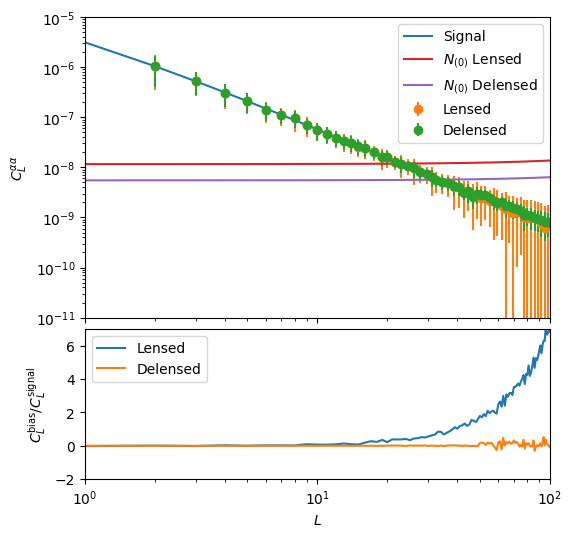

In [35]:
qcl_real_binned = []
qcl_delens_binned = []
for i in range(100):
    clr = qcl_real[i] - lensing_bias
    cld = qcl_delens[i] 
    bc, bpr = bin_power_spectrum(200,clr,'sqrt')
    bc, bpd = bin_power_spectrum(200,cld,'sqrt')
    qcl_real_binned.append(bpr)
    qcl_delens_binned.append(bpd)
qcl_real_binned = np.array(qcl_real_binned)
qcl_delens_binned = np.array(qcl_delens_binned)
fig, axes = plt.subplots(2, 1, figsize=(6, 6), sharex=True, 
                         gridspec_kw={'height_ratios': [2, 1], 'hspace': 0.05})

# Upper plot
ax = axes[0]
ax.loglog(cl_aa, label='Signal')
ax.errorbar(bc, qcl_real_binned.mean(axis=0), yerr=qcl_real_binned.std(axis=0), 
            fmt='o', label='Lensed', markersize=6)
ax.errorbar(bc, qcl_delens_binned.mean(axis=0), yerr=qcl_delens_binned.std(axis=0), 
            fmt='o', label='Delensed', markersize=6)
ax.loglog(n0_real.mean(axis=0), label=r'$N_{(0)}$ Lensed')
ax.loglog(n0_delens.mean(axis=0), label=r'$N_{(0)}$ Delensed')

ax.set_ylim(1e-11, 1e-5)
ax.set_xlim(1, 100)
ax.set_ylabel(r'$C^{\alpha \alpha}_L$')
ax.legend()

# Lower plot
ax = axes[1]
ax.plot(lensing_bias / cl_aa, label="Lensed")
ax.plot(delensed_bias / cl_aa, label="Delensed")
ax.set_xlim(1, 100)
ax.set_ylim(-2, 7)
ax.set_xlabel('$L$')
ax.set_ylabel(r'$C_L^{\mathrm{bias}} / C_L^{\mathrm{signal}}$')
ax.legend()


In [46]:
sel = np.where(bc<=100)[0]
BC = bc[sel]
QCL_LENS_MEAN = qcl_real_binned.mean(axis=0)[sel]
QCL_LENS_STD = qcl_real_binned.std(axis=0)[sel]
QCL_DELENS_MEAN = qcl_delens_binned.mean(axis=0)[sel]
QCL_DELENS_STD = qcl_delens_binned.std(axis=0)[sel]

In [53]:
def theory_alpha(Acb):
    return Acb * 2 * np.pi / ( BC**2 + BC + 1e-30)

In [54]:
def chi_sq_lens(Acb):
    return np.sum((QCL_LENS_MEAN - theory_alpha(Acb))**2 / QCL_LENS_STD**2)

def chi_sq_delens(Acb):
    return np.sum((QCL_DELENS_MEAN - theory_alpha(Acb))**2 / QCL_DELENS_STD**2)

def log_likelihood_lens(Acb):
    return -0.5 * chi_sq_lens(Acb)

def log_likelihood_delens(Acb):
    return -0.5 * chi_sq_delens(Acb)

# Define log-prior
def log_prior(Acb):
    if 0 < Acb < 1e-4:  # Prior range to keep values reasonable
        return -0.5 * ((Acb - 1e-6) / 1e-6)**2  # Gaussian prior centered at 1e-6
    return -np.inf  # Return -inf for invalid values

# Define log-posterior functions
def log_posterior_lens(Acb):
    lp = log_prior(Acb)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood_lens(Acb)

def log_posterior_delens(Acb):
    lp = log_prior(Acb)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood_delens(Acb)


In [75]:

# MCMC settings
ndim = 1  # Number of parameters
nwalkers = 100  # Number of walkers
nsteps = 10000  # Number of steps

# Initialize walkers around expected value
initial_pos = 1e-6 + 1e-7 * np.random.randn(nwalkers, ndim)

# Run MCMC for lensed case
sampler_lens = emcee.EnsembleSampler(nwalkers, ndim, log_posterior_lens)
sampler_lens.run_mcmc(initial_pos, nsteps, progress=True)

# Run MCMC for delensed case
sampler_delens = emcee.EnsembleSampler(nwalkers, ndim, log_posterior_delens)
sampler_delens.run_mcmc(initial_pos, nsteps, progress=True)

# Extract samples
samples_lens = sampler_lens.get_chain(discard=100, thin=10, flat=True)
samples_delens = sampler_delens.get_chain(discard=100, thin=10, flat=True)



  0%|          | 0/10000 [00:00<?, ?it/s]

100%|██████████| 10000/10000 [00:26<00:00, 382.10it/s]


In [84]:
#plot_posterior([samples_lens.T*1e6,samples_delens.T*1e6],'Acb',['Lensed','Delensed'],backend='sklearn',bandwidth=0.05)

In [83]:
1 - (4.96/7.22)

0.31301939058171746